In [1]:
from sklearn import datasets, model_selection, linear_model, metrics, preprocessing, svm, neighbors, tree
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
% matplotlib inline
import math
import seaborn as sns

In [2]:
import warnings
warnings.simplefilter('ignore')

## SMOTE implementation and testing

In [188]:
# function applies SMOTE algorithm to input dataframe using k-neighbours
# inputs: dataframe - pd.DataFrame, last column should comtain labels
#         k - number of neighbors for the algorithm
def smote(dataframe, k, random_state=0):
    # get the labels of input dataframe
    np.random.seed(random_state)
    labels = dataframe.iloc[:, -1]
    # extract unique labels and count number of examples for each one
    unq_labels, cnt_labels = np.unique(labels, return_counts=True)
    # detect minor class and major class
    unq_labels = list(unq_labels)
    cnt_labels = list(cnt_labels)
    imbalanced_label = unq_labels.index(cnt_labels.index(min(cnt_labels)))
    max_label = unq_labels.index(cnt_labels.index(max(cnt_labels)))
    # calculate for how many times minor class should be extended to reach major one
    num_imbalanced = min(cnt_labels)
    num_max_label = max(cnt_labels)
    increase_rate = int(num_max_label / num_imbalanced) - 1
    synth_data = []
    
    print "Scaling has started.."
    # rescale Dataframe values
    columns = dataframe.columns
    labels = np.array(dataframe.iloc[:, -1])
    scaler = preprocessing.MinMaxScaler()
    data = dataframe.iloc[:, :-1]
    scaler.fit(data)
    scaled_data = scaler.transform(data)
    dataframe = pd.DataFrame(scaled_data)
    dataframe['label'] = labels
    
    # extract minor class examples
    imbalanced_class = dataframe.loc[dataframe.iloc[:, -1] == 0]
    
    for i in range(num_imbalanced):
        print i
        # fit nearest neighbors, number is k + 1 to find k neighbors apart from duplicate which is always the first
        neigh = neighbors.NearestNeighbors(n_neighbors=k + 1)
        neigh.fit(dataframe.iloc[:, :-1], dataframe.iloc[:, -1])
        # find indices of kneighbors in input dataset
        ind_array = neigh.kneighbors(X=[imbalanced_class.iloc[i, :-1]],return_distance=False)
        # generate synthetic datapoints for minor class i-th example
        new_data = populate(dataframe, imbalanced_class, increase_rate, i, ind_array, random_state)
        for j in range(len(new_data)):
            synth_data.append(new_data[j])   
    # process synthetic datapoints and merge with initial dataset        
    synth_data = np.array(synth_data)
    synth_data_dataframe = pd.DataFrame(synth_data)
    synth_data_dataframe.columns = dataframe.iloc[:, :-1].columns
    synth_labels = [imbalanced_label for i in range(synth_data_dataframe.shape[0])]
    synth_data_dataframe['label'] = synth_labels
    new_dataframe = pd.concat([dataframe, synth_data_dataframe])
    
    print "Inverse scaling has started.."
    # inverse scaling 
    labels = np.array(new_dataframe.iloc[:, -1])
    new_data = new_dataframe.iloc[:, :-1]
    scaled_new_data = scaler.inverse_transform(new_data)
    new_dataframe = pd.DataFrame(scaled_new_data)
    new_dataframe['label'] = labels
    new_dataframe.columns = columns
    new_dataframe = new_dataframe.sample(frac=1, random_state=random_state)
    return new_dataframe
 
# function generates synthetic datapoints using a datapoint and its nearest neighbors indices
# inputs: dataframe - initial imbalanced dataframe
#         imbalanced_class - dataframe containing only minor class
#         inc_rate - hom many times minor class should be extended
#         i - index of minor class example
#         ind_array - array containing nearest neighbors indices in initital imbalanced dataframe 
def populate(dataframe, imbalanced_class, inc_rate, i, ind_array, random_state):
    # list for new synthetic data
    np.random.seed(random_state)
    synth_data = []
    while inc_rate != 0:
        # choose random neighbour from 1 to k, ignore 0 because it is duplicate
        rand_k = int(np.random.random() * ind_array[0].shape[0] - 1) + 1
        # list for attributes of one datapoint
        new_datapoint = []
        for attr in range(dataframe.iloc[:, :-1].shape[1]):
            # calculate distance between neighbour and input minor class datapoint
            dist = float(dataframe.iloc[ind_array[:, rand_k], attr]) - float(imbalanced_class.iloc[i, attr])
            gap = np.random.random()
            # add attribute for synthetic datapoint
            new_datapoint.append(imbalanced_class.iloc[i, attr] + gap * dist)
        # append datapoint to the list with synthetic datapoints    
        synth_data.append(new_datapoint)
        inc_rate -= 1
    return synth_data     

In [189]:
def plot_blobs(blobs, title):
    label_0 = blobs.loc[blobs['label'] == 0]
    label_1 = blobs.loc[blobs['label'] == 1]
    plt.title(title)
    plt.scatter(label_0.x1, label_0.x2, marker='o')
    plt.scatter(label_1.x1, label_1.x2, marker='x')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

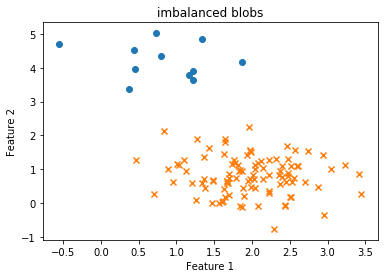

In [190]:
blobs = pd.read_csv('./imbalanced_datasets/imbalanced_blobs.csv')
plot_blobs(blobs, 'imbalanced blobs')

Scaling has started..
0
1
2
3
4
5
6
7
8
9
10
Inverse scaling has started..
Number of class 0 after SMOTE: 99
Number of class 1 after SMOTE: 100


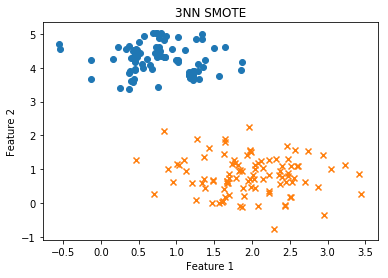

In [191]:
smote_blobs_3 = smote(blobs, 3)
print 'Number of class 0 after SMOTE:', smote_blobs_3.loc[smote_blobs_3['label'] == 0].shape[0]
print 'Number of class 1 after SMOTE:', smote_blobs_3.loc[smote_blobs_3['label'] == 1].shape[0]
plot_blobs(smote_blobs_3, '3NN SMOTE')

Scaling has started..
0
1
2
3
4
5
6
7
8
9
10
Inverse scaling has started..


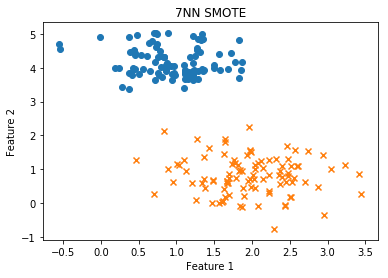

In [192]:
smote_blobs_7 = smote(blobs, 7)
plot_blobs(smote_blobs_7, '7NN SMOTE')

Scaling has started..
0
1
2
3
4
5
6
7
8
9
10
Inverse scaling has started..


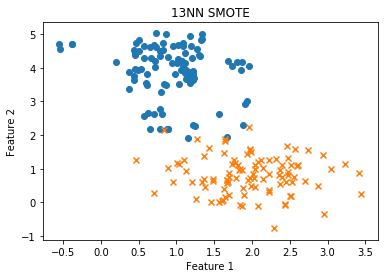

In [193]:
smote_blobs_13 = smote(blobs, 13)
plot_blobs(smote_blobs_13, '13NN SMOTE')

Scaling has started..
0
1
2
3
4
5
6
7
8
9
10
Inverse scaling has started..


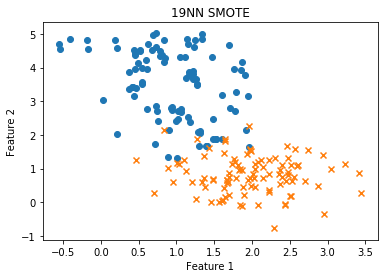

In [194]:
smote_blobs_19 = smote(blobs, 19)
plot_blobs(smote_blobs_19, '19NN SMOTE')

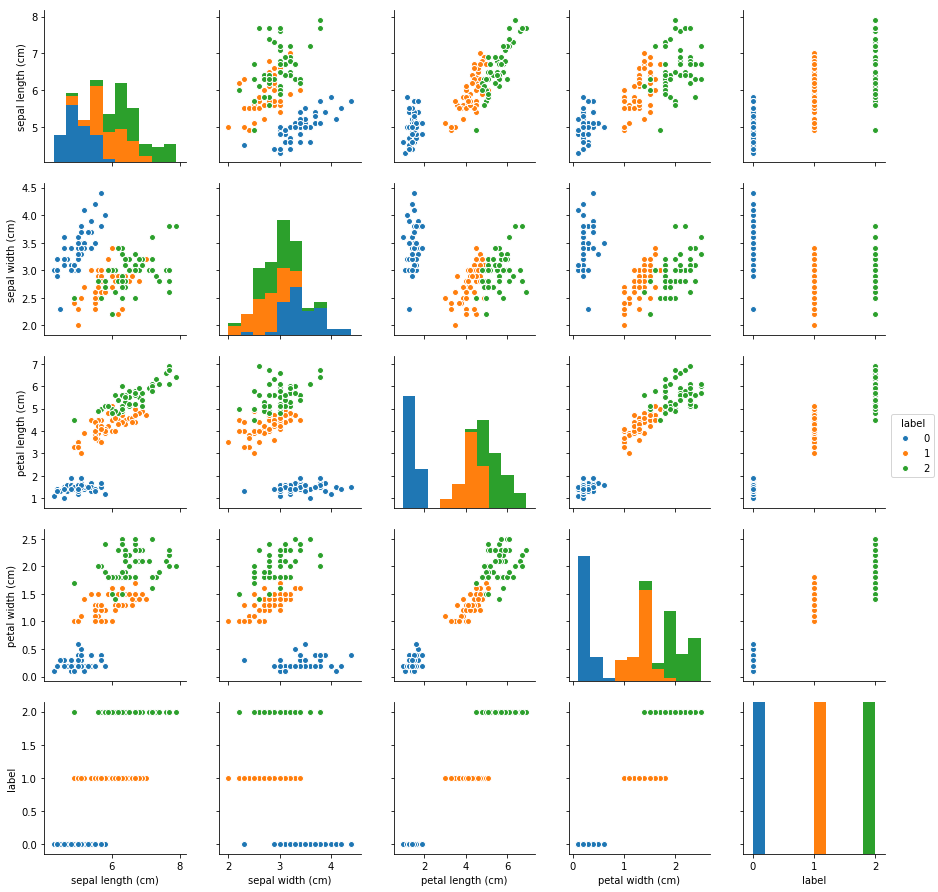

In [195]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data)
iris_df.columns = iris.feature_names
iris_df['label'] = iris.target
sns.pairplot(iris_df, hue='label')

In [196]:
iris_imb = pd.read_csv('./imbalanced_datasets/imbalanced_iris.csv')

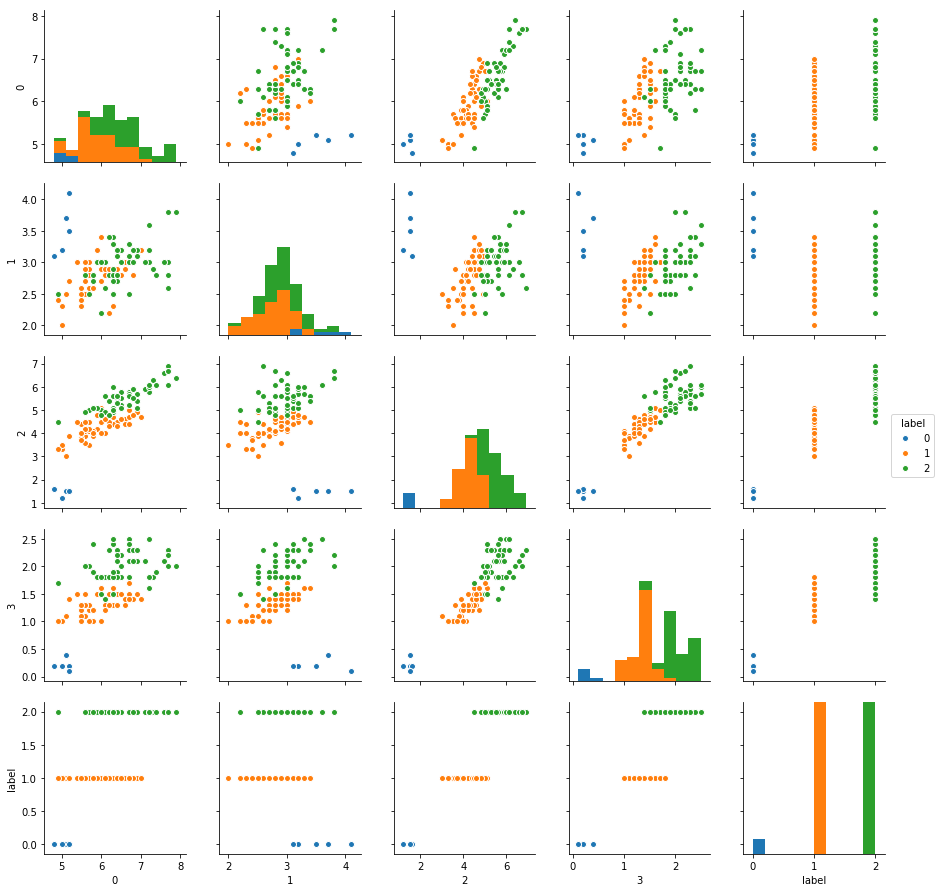

In [197]:
sns.pairplot(iris_imb, hue='label')

Scaling has started..
0
1
2
3
4
Inverse scaling has started..


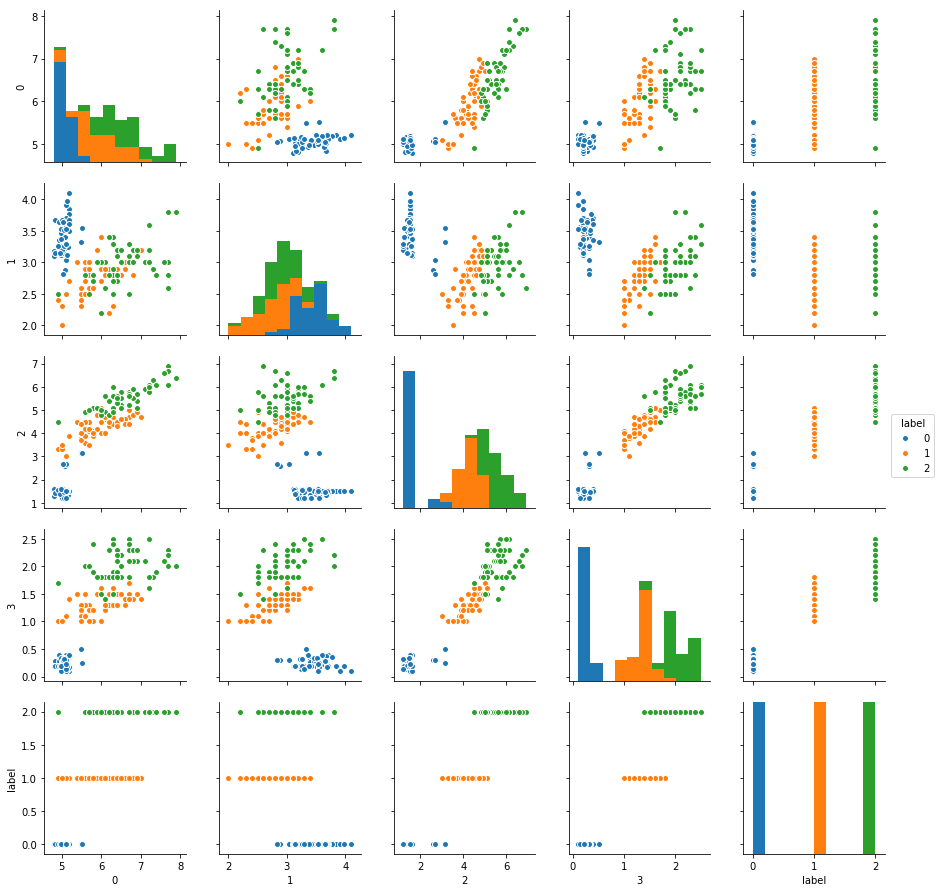

In [198]:
iris_smote = smote(iris_imb, 5)
sns.pairplot(iris_smote, hue='label')

## Training and Testing 

### Functions

In [199]:
def get_prc_rcl(conf_matrix):
    prcs = ''
    rcls = ''
    f_meas = ''
#     print conf_matrix
    for i in range(conf_matrix.shape[0]):
        tmp_prc = round(conf_matrix[i][i] * 1.0 / sum(conf_matrix[:, i]), 3)
        tmp_rcl = round(conf_matrix[i][i] * 1.0 / sum(conf_matrix[i]), 3)
        if math.isnan(tmp_prc):
            tmp_prc = 0
        if math.isnan(tmp_rcl):
            tmp_rcl = 0    
        if tmp_prc == 0 and tmp_rcl == 0:
            tmp_f_meas = 0
        else:
            tmp_f_meas = round(2 * (tmp_prc * tmp_rcl/(tmp_prc + tmp_rcl)), 3)
        prcs += str(tmp_prc) 
        rcls += str(tmp_rcl) 
        f_meas += str(tmp_f_meas)
        if i < conf_matrix.shape[0] - 1:
            prcs += ' / '
            rcls += ' / '
            f_meas += ' / '
    return prcs, rcls, f_meas

In [254]:
def train_model(clf_name, data, target, labels=[0, 1], random_state=15, cv=5, n_iter=10, undersample=False, \
                undersample_prop=10, apply_smote=False, knn_smote=3, standard=True):
    cv = model_selection.KFold(n_splits=cv,random_state=random_state)
    accs = []
    rcls = []
    prcs = []
    conf_matr = np.zeros((np.unique(target).size, np.unique(target).size))
    for train_inds, test_inds in cv.split(data):
        
        if clf_name == 'log':
            clf = linear_model.SGDClassifier(random_state=random_state, n_iter=n_iter)
        if clf_name == 'svm':
            clf = svm.SVC(kernel='linear', random_state=random_state)
        if clf_name == '5nn':
            clf = neighbors.KNeighborsClassifier(n_neighbors=5)
        if clf_name == 'tree':
            clf = tree.DecisionTreeClassifier(max_depth=10, random_state=random_state)
        
        train_data = data[train_inds]
        train_labels = target[train_inds]
        test_data = data[test_inds]
        test_labels = target[test_inds]
        
        if undersample:
            train_df = pd.DataFrame(train_data)
            train_df['label'] = train_labels
            undersampled_train_df = random_undersampling(train_df, undersample_prop)
            train_data = np.array(undersampled_train_df.iloc[:, :-1])
            train_labels = np.array(undersampled_train_df.iloc[:, -1])
        
        if apply_smote:
            train_df = pd.DataFrame(train_data)
            train_df['label'] = train_labels
            smote_train_df = smote(train_df, knn_smote)
            train_data = np.array(smote_train_df.iloc[:, :-1])
            train_labels = np.array(smote_train_df.iloc[:, -1])
        
        if standard:
            scaler = preprocessing.MinMaxScaler().fit(train_data)
            train_data = scaler.transform(train_data)
            test_data = scaler.transform(test_data)
            
        clf.fit(train_data, train_labels)
        accs.append(clf.score(test_data, test_labels))
        conf_matr += metrics.confusion_matrix(y_true=test_labels, y_pred=clf.predict(test_data), labels=labels)
    mean_acc = np.array(accs).mean()
    prcs, rcls, f_meas = get_prc_rcl(conf_matrix=conf_matr)  
    return mean_acc, prcs, rcls, f_meas, conf_matr

In [256]:
def test_dataset(data, target, name, labels=[0, 1], classifiers = ['log', 'svm', '5nn', 'tree'], n_iter=10, \
                 undersample=False, undersample_prop=10, apply_smote=False, knn_smote=3, standard=True):
    columns = ['dataset', 'algorithm', 'mean accuracy', 'precision', 'recall', 'F-measure']
    df = pd.DataFrame(columns=columns)    
    for clf in classifiers:
        print clf, 'is running'
        acc, prcs, rcls, f_meas, conf_matr = train_model(clf_name=clf, data=data, target=target, \
                                                         n_iter=n_iter, undersample=undersample,\
                                                         undersample_prop=undersample_prop, apply_smote=apply_smote, \
                                                         knn_smote=knn_smote, standard=standard, labels=labels)
        row = [name, clf, round(acc, 3), prcs, rcls, f_meas]
        df.loc[classifiers.index(clf)] = row
    return df        

### Toy datasets

#### Breast Cancer

In [202]:
bc = datasets.load_breast_cancer()
test_dataset(bc.data, bc.target, name = 'bc', labels=[0, 1], standard=True, n_iter=10)

log is running
[[202.  10.]
 [  7. 350.]]
svm is running
[[200.  12.]
 [  2. 355.]]
5nn is running
[[196.  16.]
 [  6. 351.]]
tree is running
[[190.  22.]
 [ 32. 325.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,bc,log,0.970,0.967 / 0.972,0.953 / 0.98,0.96 / 0.976
1,bc,svm,0.975,0.99 / 0.967,0.943 / 0.994,0.966 / 0.98
2,bc,5nn,0.961,0.97 / 0.956,0.925 / 0.983,0.947 / 0.969
3,bc,tree,0.905,0.856 / 0.937,0.896 / 0.91,0.876 / 0.923


In [203]:
imb_bc = pd.read_csv('./imbalanced_datasets/imbalanced_breast_cancer.csv')
imb_bc_data = np.array(imb_bc.iloc[:,:-1])
imb_bc_label = np.array(imb_bc.iloc[:,-1])
# print(imb_bc.loc[imb_bc['label'] == 0].shape[0])
test_dataset(imb_bc_data, imb_bc_label, name='imb_bc', labels=[0, 1], standard=True, n_iter=10)

log is running
[[ 15.   4.]
 [  0. 357.]]
svm is running
[[ 14.   5.]
 [  0. 357.]]
5nn is running
[[ 11.   8.]
 [  0. 357.]]
tree is running
[[ 16.   3.]
 [  4. 353.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,imb_bc,log,0.989,1.0 / 0.989,0.789 / 1.0,0.882 / 0.994
1,imb_bc,svm,0.987,1.0 / 0.986,0.737 / 1.0,0.849 / 0.993
2,imb_bc,5nn,0.979,1.0 / 0.978,0.579 / 1.0,0.733 / 0.989
3,imb_bc,tree,0.981,0.8 / 0.992,0.842 / 0.989,0.82 / 0.99


In [204]:
test_dataset(imb_bc_data, imb_bc_label, name='smote_bc', apply_smote=True, knn_smote=5, labels = [0, 1], standard=True, n_iter=10)

log is running
Scaling has started..
0
1
2
3
4
5
6
7
8
9
10
11
Inverse scaling has started..
Scaling has started..
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Inverse scaling has started..
Scaling has started..
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Inverse scaling has started..
Scaling has started..
0
1
2
3
4
5
6
7
8
9
10
11
12
13
Inverse scaling has started..
Scaling has started..
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
Inverse scaling has started..
[[ 18.   1.]
 [ 28. 329.]]
svm is running
Scaling has started..
0
1
2
3
4
5
6
7
8
9
10
11
Inverse scaling has started..
Scaling has started..
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Inverse scaling has started..
Scaling has started..
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Inverse scaling has started..
Scaling has started..
0
1
2
3
4
5
6
7
8
9
10
11
12
13
Inverse scaling has started..
Scaling has started..
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
Inverse scaling has started..
[[ 18.   1.]
 [ 14. 343.]]
5nn is running
Scaling has started..
0
1

,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,smote_bc,log,0.923,0.391 / 0.997,0.947 / 0.922,0.553 / 0.958
1,smote_bc,svm,0.960,0.563 / 0.997,0.947 / 0.961,0.706 / 0.979
2,smote_bc,5nn,0.944,0.472 / 0.994,0.895 / 0.947,0.618 / 0.97
3,smote_bc,tree,0.944,0.471 / 0.991,0.842 / 0.95,0.604 / 0.97


#### Iris

In [205]:
iris = datasets.load_iris()
test_dataset(iris.data, iris.target, name = 'iris', labels = [0, 1, 2], standard=True, n_iter=1000)

log is running
[[49.  1.  0.]
 [ 2. 33. 15.]
 [ 0.  5. 45.]]
svm is running
[[50.  0.  0.]
 [ 0. 35. 15.]
 [ 0. 14. 36.]]
5nn is running
[[50.  0.  0.]
 [ 0. 45.  5.]
 [ 0.  8. 42.]]
tree is running
[[50.  0.  0.]
 [ 0. 46.  4.]
 [ 0. 10. 40.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,iris,log,0.847,0.961 / 0.846 / 0.75,0.98 / 0.66 / 0.9,0.97 / 0.742 / 0.818
1,iris,svm,0.807,1.0 / 0.714 / 0.706,1.0 / 0.7 / 0.72,1.0 / 0.707 / 0.713
2,iris,5nn,0.913,1.0 / 0.849 / 0.894,1.0 / 0.9 / 0.84,1.0 / 0.874 / 0.866
3,iris,tree,0.907,1.0 / 0.821 / 0.909,1.0 / 0.92 / 0.8,1.0 / 0.868 / 0.851


In [206]:
imb_iris = pd.read_csv('./imbalanced_datasets/imbalanced_iris.csv')
imb_iris_data = np.array(imb_iris.iloc[:,:-1])
imb_iris_label = np.array(imb_iris.iloc[:,-1])
test_dataset(imb_iris_data, imb_iris_label, name='imb_iris', labels=[0, 1, 2], standard=True)

log is running
[[ 0.  5.  0.]
 [ 0. 44.  6.]
 [ 0.  4. 46.]]
svm is running
[[ 4.  1.  0.]
 [ 0. 48.  2.]
 [ 0.  4. 46.]]
5nn is running
[[ 2.  3.  0.]
 [ 0. 47.  3.]
 [ 0.  5. 45.]]
tree is running
[[ 5.  0.  0.]
 [ 0. 46.  4.]
 [ 0.  6. 44.]]


,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,imb_iris,log,0.857,0 / 0.83 / 0.885,0.0 / 0.88 / 0.92,0 / 0.854 / 0.902
1,imb_iris,svm,0.933,1.0 / 0.906 / 0.958,0.8 / 0.96 / 0.92,0.889 / 0.932 / 0.939
2,imb_iris,5nn,0.895,1.0 / 0.855 / 0.938,0.4 / 0.94 / 0.9,0.571 / 0.895 / 0.919
3,imb_iris,tree,0.905,1.0 / 0.885 / 0.917,1.0 / 0.92 / 0.88,1.0 / 0.902 / 0.898


In [207]:
test_dataset(imb_iris_data, imb_iris_label, name='smote_iris', apply_smote=True, labels = [0, 1, 2], standard=True, n_iter=100)

log is running
Scaling has started..
0
1
2
3
Inverse scaling has started..
Scaling has started..
0
1
2
3
Inverse scaling has started..
Scaling has started..
0
1
Inverse scaling has started..
Scaling has started..
0
1
2
3
4
Inverse scaling has started..
Scaling has started..
0
1
2
3
4
Inverse scaling has started..
[[ 5.  0.  0.]
 [ 4. 40.  6.]
 [ 0.  5. 45.]]
svm is running
Scaling has started..
0
1
2
3
Inverse scaling has started..
Scaling has started..
0
1
2
3
Inverse scaling has started..
Scaling has started..
0
1
Inverse scaling has started..
Scaling has started..
0
1
2
3
4
Inverse scaling has started..
Scaling has started..
0
1
2
3
4
Inverse scaling has started..
[[ 5.  0.  0.]
 [ 0. 48.  2.]
 [ 0.  4. 46.]]
5nn is running
Scaling has started..
0
1
2
3
Inverse scaling has started..
Scaling has started..
0
1
2
3
Inverse scaling has started..
Scaling has started..
0
1
Inverse scaling has started..
Scaling has started..
0
1
2
3
4
Inverse scaling has started..
Scaling has started..
0
1

,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,smote_iris,log,0.857,0.556 / 0.889 / 0.882,1.0 / 0.8 / 0.9,0.715 / 0.842 / 0.891
1,smote_iris,svm,0.943,1.0 / 0.923 / 0.958,1.0 / 0.96 / 0.92,1.0 / 0.941 / 0.939
2,smote_iris,5nn,0.924,1.0 / 0.904 / 0.938,1.0 / 0.94 / 0.9,1.0 / 0.922 / 0.919
3,smote_iris,tree,0.895,1.0 / 0.868 / 0.915,1.0 / 0.92 / 0.86,1.0 / 0.893 / 0.887


### Credit Card Fraud

#### Random undersampling

In [208]:
def random_undersampling(dataframe, n, random_state = 0):
    np.random.seed(random_state)
    # all unique label values
    labels = list(dataframe.iloc[:, -1].unique())
    labels.sort()
    # count number of examples for each label
    count_labels = []
    for label in labels:
        count_labels.append(dataframe.loc[dataframe.iloc[:, -1] == label].shape[0])
    # major class label
    major_label = count_labels.index(max(count_labels))
    # dataframe containing only major class examples
    major_class_df = dataframe.loc[dataframe.iloc[:, -1] == major_label]
    # calculate number of major class examples after undersampling
    remain_examples = round(major_class_df.shape[0] * 1.0 / n, 0)
    
    random_inds = []
    while remain_examples != 0:
        tmp_rand = int(np.random.rand() * major_class_df.shape[0])
        if tmp_rand not in random_inds:
            random_inds.append(tmp_rand)
            remain_examples -= 1
    remain_major_examples = major_class_df.iloc[random_inds]
    df_without_major = dataframe.loc[dataframe.iloc[:, -1] != major_label]
    undersampled_dataframe = df_without_major.append(remain_major_examples)
    undersampled_dataframe = undersampled_dataframe.sample(frac=1, random_state=random_state)
    return undersampled_dataframe

In [275]:
credit_card = pd.read_csv('./credit_card/creditcard.csv')
# data and label of the credit card dataset
cc_data = credit_card.iloc[:, 1:-1]
cc_label = credit_card.iloc[:, -1]

In [ ]:
# train classifiers on the original datasets
import time
start_time = time.clock()
cc_test = test_dataset(np.array(cc_data), np.array(cc_label), name='credit_card', labels=[0, 1], standard=True)
finish_time = time.clock()

In [ ]:
print "Time to train and test model on the original dataset", finish_time - start_time

In [ ]:
cc_test

In [276]:
# train classifiers on the original datasets with undersampling
import time
start_time = time.clock()
under_cc_test = test_dataset(np.array(cc_data), np.array(cc_label), name='credit_card', \
                             labels=[0, 1], standard=True, \
                            undersample=True)
finish_time = time.clock()

log is running
[[2.84233e+05 8.20000e+01]
 [9.80000e+01 3.94000e+02]]
svm is running
[[2.84234e+05 8.10000e+01]
 [9.80000e+01 3.94000e+02]]
5nn is running
[[2.8418e+05 1.3500e+02]
 [9.3000e+01 3.9900e+02]]
tree is running
[[2.83776e+05 5.39000e+02]
 [9.10000e+01 4.01000e+02]]


In [277]:
under_cc_test

,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,credit_card,log,0.999,1.0 / 0.828,1.0 / 0.801,1.0 / 0.814
1,credit_card,svm,0.999,1.0 / 0.829,1.0 / 0.801,1.0 / 0.815
2,credit_card,5nn,0.999,1.0 / 0.747,1.0 / 0.811,1.0 / 0.778
3,credit_card,tree,0.998,1.0 / 0.427,0.998 / 0.815,0.999 / 0.56


In [263]:
print "Time to train and test model on the original dataset:", (finish_time - start_time) / 60, " minutes"

Time to train and test model on the original dataset: 0.178264103934  minutes


In [273]:
# train classifiers on the original datasets with undersampling and SMOTE both
import time
start_time = time.clock()
under_smote_cc_test = test_dataset(np.array(cc_data), np.array(cc_label), name='credit_card', \
                             labels=[0, 1], standard=True, \
                            undersample=True, apply_smote=True, knn_smote=5,\
                                  classifiers=[])
finish_time = time.clock()

tree is running
Scaling has started..
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267


In [274]:
under_smote_cc_test

,dataset,algorithm,mean accuracy,precision,recall,F-measure
0,credit_card,tree,0.633,0.997 / 0.04,0.629 / 0.89,0.771 / 0.077
